In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split, KFold
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, Lars
from sklearn.learning_curve import learning_curve, validation_curve
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error

%matplotlib inline

# Data Fields

- **datetime** - hourly date + timestamp  
- **season** -  1 = spring, 2 = summer, 3 = fall, 4 = winter 
- **holiday** - whether the day is considered a holiday
- **workingday** - whether the day is neither a weekend nor holiday
- **weather** 

    - 1: Clear, Few clouds, Partly cloudy, Partly cloudy 
    - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist 
    - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds 
    - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 


- **temp** - temperature in Celsius
- **atemp** - "feels like" temperature in Celsius
- **humidity** - relative humidity
- **windspeed** - wind speed
- **casual** - number of non-registered user rentals initiated
- **registered** - number of registered user rentals initiated
- **count** - number of total rentals

##### Load Clean and Dummy-ize our variables

In [13]:
train = pd.read_csv('data/train.csv')
hold_out = pd.read_csv('data/test.csv')

def clean_frame(df, test_data=False):
    seasons = {'spring':1, 'summer':2, 'winter':3, 'fall':4}
    for season in seasons.iterkeys():
        df[season] = df['season'].isin([seasons[season]])

    weather_types = {'clear':1, 'mist':2, 'light':3, 'heavy':4}
    for weather in weather_types:
        df[weather] = df['weather'].isin([weather_types[weather]])

    ### drop stuff we don't need ###
    df = df.drop(['season', 'weather'], axis=1)
    df = df.set_index('datetime')

    ### Rearrange columns
    if not test_data:
        cols = df.columns
        cols = cols[6:9].append(cols[:6]).append(cols[9:])
        df = df[cols]
        df.index = pd.to_datetime(df.index)
    return df

train = clean_frame(train)

### Collinearity

Weather, humidity, temperature are collinear with the seasons, so any time series analysis would need to account for this effect. 

I suspect that weather's effect on whether people will use a bike are somewhat transient.  70 degrees feels like a great day for a bike ride, but if it's been 40 degrees for weeks, a 55 degree day may also feel similar.  

In [14]:
def pairplot(train, pair_variables, y_var):
    g = sns.pairplot(train[pair_variables],
                 kind='reg',
                 x_vars=pair_variables,
                y_vars=y_var,
                size=5)
    g.set(ylim=(0, 1500))


# Observations: Which Variables effect the outcome?

### Count against weather stats

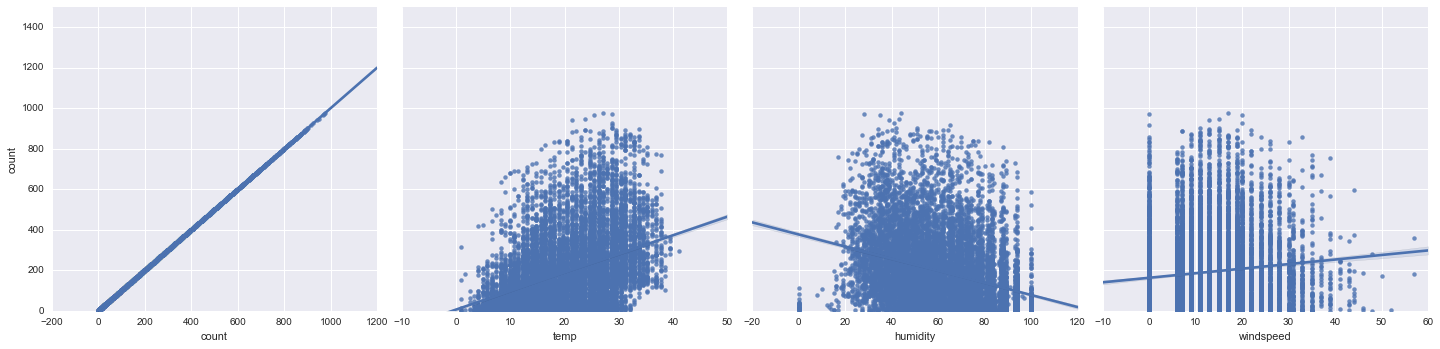

In [15]:
y = 'count'
pairplot(train, [y, 'temp', 'humidity', 'windspeed'], y_var=[y])

### Count against Weather Type

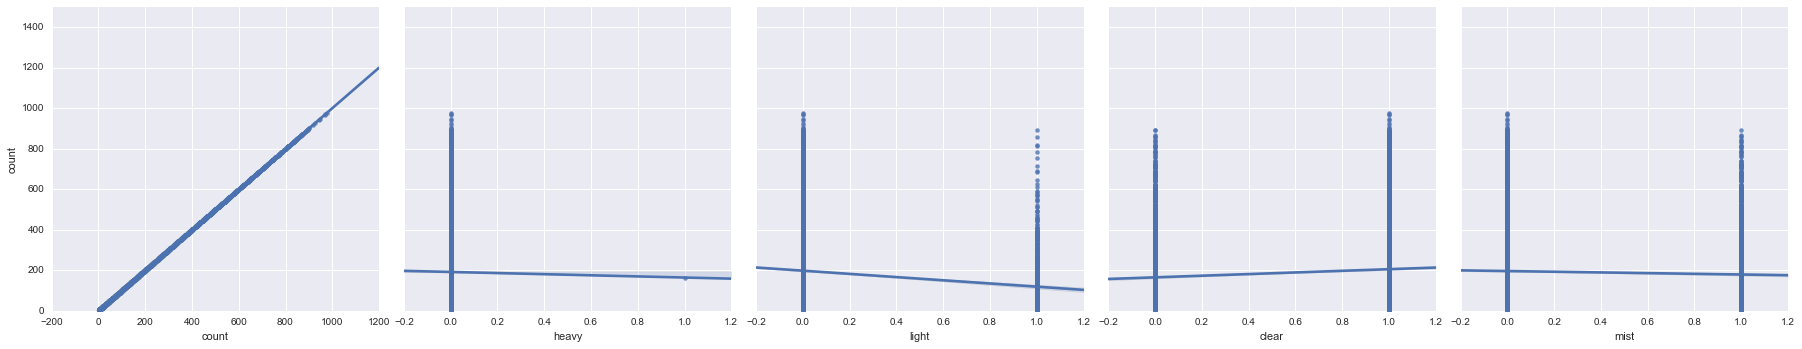

In [16]:
y = 'count'
pairplot(train, [y, 'heavy', 'light', 'clear', 'mist'], y_var=[y])

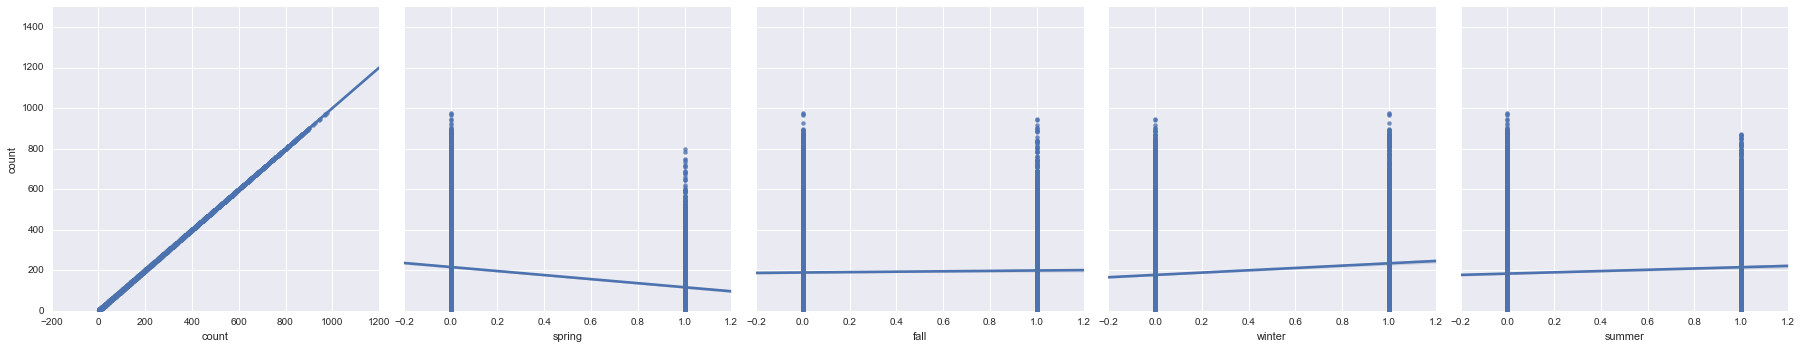

In [17]:
y = 'count'
pairplot(train, [y, 'spring', 'fall', 'winter', 'summer'], y_var=[y])

##### Let's look at how bike usage varies with time.  

In [18]:
train_wk_day = train[train['workingday'] == 1]
train_wknd = train[train['workingday'] == 0]

''

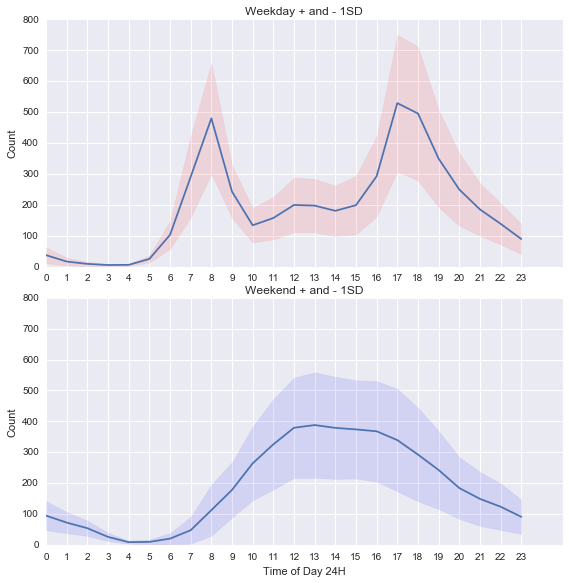

In [19]:
train_hours = train_wk_day.groupby(train_wk_day.index.hour)[['count', 'registered', 'casual']].mean()
std = train_wk_day.groupby(train_wk_day.index.hour)['count'].std()

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(2, 1, 1)
ax.plot(train_hours.drop(['registered', 'casual'], axis=1))

ax.fill_between(train_hours.index, train_hours['count'] - std,
                 train_hours['count'] + std, alpha=0.1, 
                                                    color="r")

plt.xticks(range(0, 24, 1))
plt.ylim(0, 800)
plt.title('Weekday + and - 1SD')
plt.ylabel('Count')

### Second Plot
train_wknd_hours = train_wknd.groupby(train_wknd.index.hour)[['count','registered','casual']].mean()
std_wknd = train_wknd.groupby(train_wknd.index.hour)['count'].std()

# train_wknd_hours.plot(xticks=range(0,23,1), ylim=(0, 600))
ax1 = fig.add_subplot(2, 1, 2)
ax1.plot(train_wknd_hours.drop(['registered', 'casual'], axis=1))
ax1.fill_between(train_wknd_hours.index, train_wknd_hours['count'] - std_wknd,
                 train_wknd_hours['count'] + std_wknd, alpha=0.1, 
                                                    color="b")


plt.xticks(range(0, 24, 1))
plt.ylim(0,800)
fig.tight_layout()
plt.xlabel('Time of Day 24H')
plt.title('Weekend + and - 1SD')
plt.ylabel('Count')
plt.savefig('/Users/ryanlambert/Desktop/bikes_per_hour.png')
;

# Observations

Based on what I have seen thus far I'm going to include hour of day as a dummy variable.  

There is a clear signal that is a function of what time of day it is.  

##### Tools

In [20]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and traning learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : integer, cross-validation generator, optional
        If an integer is passed, it is the number of folds (defaults to 3).
        Specific cross-validation objects can be passed, see
        sklearn.cross_validation module for the list of possible objects

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

def plot_validation_curve(X, y, estimator, param_range=np.logspace(-6, 6, 4), param_name='ridge__alpha'):
    train_scores, test_scores = validation_curve(
        estimator, X, y, param_name=param_name,
        param_range=param_range, cv=KFold(X.shape[0], n_folds=10, shuffle=True))
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)

    fig = plt.figure(figsize=(8, 5))
    ax = fig.add_subplot(111)

    ax.semilogx(param_range, train_scores_mean, label="Training score", color="r")
    ax.fill_between(param_range, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.2, color="r")
    ax.semilogx(param_range, test_scores_mean, label="Cross-validation score",
                 color="g")
    ax.fill_between(param_range, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.2, color="g")
    
    plt.title("Validation Curve Multiple Regression")
    plt.xlabel("Alpha")
    plt.ylabel("Score")
    plt.ylim(0.0, 1.1)

    plt.legend(loc="best")
    plt.show()

def resid_plot(X, y, est):
    y_pred = est.predict(X)
    residuals = y - y_pred

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(y, residuals)
    plt.title('Residuals VS Fitted')

    ax1 = fig.add_subplot(1, 2, 2)
    ax1.hist(residuals, orientation='horizontal')
    plt.title('Hist of Residuals')
    
#     fig2 = plt.figure(figsize=(5, 5))
#     ax2 = fig2.add_subplot(1, 1, 1)
#     ax2.hexbin(y, residuals)
#     plt.title('Residuals VS Fitted')
    
def score_model(X, y, est):
    kf=KFold(X.shape[0], n_folds=10, shuffle=True)
    scores = cross_val_score(est, X, y, cv=kf)
    print("Cross Val Score: ", np.mean(scores))
    resid_plot(X, y, est)
    plot_learning_curve(est, 'Learning Curve', X, y, cv=kf);




# Make model without time first and see how good it is

In [ ]:
y = train.iloc[:, 2]
X = train.drop(['casual', 'registered', 'count'], axis=1)

In [ ]:
est = make_pipeline(PolynomialFeatures(2), Ridge())
est.fit(X, y)
score_model(X, y, est)

In [ ]:
plot_validation_curve(X, y, est, param_range=np.logspace(-13, 2, 4))

##### This model doesn't appear to be putting regularization to any good use.  

In [ ]:
X1 = X
y1 = y
est3 = make_pipeline(PolynomialFeatures(1), Ridge())
est3.fit(X1, y1)
score_model(X1, y1, est3)

In [ ]:
plot_validation_curve(X, y, est, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

##### Residuals are 'almost' normal, there's a bit more signal in there

### With hours as dummy variables

In [ ]:
def add_dummy_hours(train):
    train_hrs = train.join(pd.get_dummies(train.index.hour, prefix='hr').set_index(train.index))
    train_hrs.index = pd.to_datetime(train_hrs.index)
    return train_hrs

train_hrs = add_dummy_hours(train)
# train = train.join(pd.get_dummies(train.index.dayofweek, prefix='daywk').set_index(train.index))
# train.index = pd.to_datetime(train.index)
y2 = train_hrs.iloc[:, 2]
X2 = train_hrs.drop(['casual', 'registered', 'count'], axis=1)

est2 = make_pipeline(PolynomialFeatures(1), Ridge())
est2.fit(X2, y2)
score_model(X2, y2, est2)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

##### There's some improvement.  But maybe we can do better if we add some of our own features before we use Polynomials

In [ ]:
new_train = train_hrs.drop(['temp', 'humidity', 'windspeed'], axis=1)
y_dw = new_train.iloc[:, 2]
X_dw = new_train.drop(['casual', 'registered', 'count'], axis=1)

est_drop_wthr = make_pipeline(PolynomialFeatures(1), StandardScaler(), Ridge())
est_drop_wthr.fit(X_dw, y_dw)
score_model(X_dw, y_dw, est_drop_wthr)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

In [ ]:
zip(X_dw.columns, est_drop_wthr.get_params()['ridge'].coef_)

# With 2nd Order Poly

In [ ]:
new_train = train_hrs
y_2nd = new_train.iloc[:, 2]
X_2nd = new_train.drop(['casual', 'registered', 'count'], axis=1)

est_2nd = make_pipeline(PolynomialFeatures(2), Ridge())
est_2nd.fit(X_2nd, y_2nd)
score_model(X_2nd, y_2nd, est_2nd)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

In [ ]:
zip(X_2nd.columns, est_2nd.get_params()['ridge'].coef_)

# With hours X workday and hours X weekend

In [ ]:
hr_dummies_wkdy = pd.get_dummies(train.index.hour, prefix='wkdy_hr').set_index(train.index)
hr_dummies_wknd = pd.get_dummies(train.index.hour, prefix='wknd_hr').set_index(train.index)
working_day_hrs = (train['workingday'] * hr_dummies_wkdy.T).T
weekend_day_hrs = ((train['workingday'] == 0) * hr_dummies_wknd.T).T
hrs_wkday_wkend = train.join(working_day_hrs)
hrs_wkday_wkend = hrs_wkday_wkend.join(weekend_day_hrs)
hrs_wkday_wkend.index = pd.to_datetime(hrs_wkday_wkend.index)
y4 = hrs_wkday_wkend.iloc[:, 2]
X4 = hrs_wkday_wkend.drop(['casual', 'registered', 'count', 'workingday', 'holiday'], axis=1)

In [ ]:
est4 = make_pipeline(PolynomialFeatures(1), Ridge())
est4.fit(X4, y4)
score_model(X4, y4, est4)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

In [ ]:
zip(X4.columns, est4.get_params()['ridge'].coef_)

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
est5 = make_pipeline(PolynomialFeatures(1), StandardScaler(), GradientBoostingRegressor())
est5.fit(X4, y4)
score_model(X4, y4, est5)
# plot_validation_curve(X2, y2, est2, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

# Month and dayofweek as dummy variables

In [ ]:
def add_month_dummies(train_hrs):
    month_dummies = pd.get_dummies(train_hrs.index.month).set_index(train_hrs.index)
    data6 = train_hrs.join(month_dummies.set_index(train_hrs.index))
    return data6

data6 = add_month_dummies(train_hrs)

In [ ]:
y6 = data6.iloc[:, 2]
X6 = data6.drop(['casual', 'registered', 'count'], axis=1)

est6 = make_pipeline(PolynomialFeatures(2), Ridge())
est6.fit(X6, y6)
score_model(X6, y6, est6)

In [ ]:
plot_validation_curve(X6, y6, est6, param_range=np.logspace(-13, 2, 4), param_name='ridge__alpha')

In [ ]:
zip(X6.columns, est6.get_params()['ridge'].coef_)

In [ ]:
data6.shape

In [ ]:
53*53

Try model on groups that have below 600 and above 600 seperately

In [ ]:
over600 = data6[data6['count']>600]
under600 = data6[data6['count']<600]

In [ ]:
over600.groupby(over600.index.month).mean().describe()

In [ ]:
under600.groupby(under600.index.month).mean().describe()

In [ ]:
data6.shape

# Negative Binomial Because I'm modeling counts!

In [10]:
train = pd.read_csv('data/train.csv')
data = add_month_dummies(add_dummy_hours(clean_frame(train)))
data[['spring', 'fall', 'winter', 'summer', 'heavy', 'light', 'clear', 'mist']] = data[['spring', 'fall', 'winter', 'summer', 'heavy', 'light', 'clear', 'mist']].astype(int)
X_n_binom = data.drop(['casual', 'registered', 'count'], axis=1)
y_n_binom = data['count']

NameError: name 'add_month_dummies' is not defined

In [ ]:
import statsmodels.api as sm

neg_bin = sm.GLM(y_n_binom, 
                 X_n_binom_w_const.values, 
                 family=sm.genmod.families.family.NegativeBinomial(link=sm.genmod.families.links.log,
                                                                   alpha=2.7))
neg_bin_results = neg_bin.fit()
neg_bin_results.summary()

In [ ]:
y_pred = neg_bin_results.predict(X_n_binom)

In [ ]:
plt.scatter(y_pred, y_n_binom)

# Interaction terms

In [ ]:
poly = PolynomialFeatures(2, interaction_only=True)

neg_bin = sm.GLM(y_n_binom, 
                 poly.fit_transform(X_n_binom.values), 
                 family=sm.genmod.families.family.NegativeBinomial(link=sm.genmod.families.links.log,
                                                                   alpha=2.7))
neg_bin_results = neg_bin.fit()
neg_bin_results.summary()

In [ ]:
y_pred = neg_bin_results.predict(poly.fit_transform(X_n_binom))

In [11]:
plt.(y_pred, y_n_binom)

SyntaxError: invalid syntax (<ipython-input-11-9727f2ca9ad7>, line 1)

This looks better. 

# Model Stacking
More than one model to solve this system.  

________

# Submission

In [ ]:
#### Submission with Cleaning 

name = 'neg_binom'
X_test_data = get_transform_test_data(X_n_binom.columns)
X_test_data[['spring', 'fall', 'winter', 'summer', 'heavy', 'light', 'clear', 'mist']] = X_test_data[['spring', 'fall', 'winter', 'summer', 'heavy', 'light', 'clear', 'mist']].astype(int)
# X_test_data = sm.add_constant(X_test_data)
predictions = neg_bin_results.predict(poly.fit_transform(X_test_data))
kaggle_submission = pd.DataFrame(zip(test_data.index, predictions))
kaggle_submission.columns = ['datetime', 'count']
kaggle_submission = kaggle_submission.set_index('datetime')
kaggle_submission.to_csv('data/{}.csv'.format(name))

In [ ]:
def get_transform_test_data(train_x_cols):
    test_data = pd.read_csv('./data/test.csv')
    test_data = clean_frame(test_data)
    test_data = add_dummy_hours(test_data)
    test_data = add_month_dummies(test_data)
    test_data = test_data[train_x_cols]
    return test_data

def submissionize_sklearn(test_data, model, name):
    predictions = model.predict(test_data)
    kaggle_submission = pd.DataFrame(zip(test_data.index, predictions))
    kaggle_submission.columns = ['datetime', 'count']
    kaggle_submission = kaggle_submission.set_index('datetime')
    kaggle_submission.to_csv('data/{}.csv'.format(name))

##### Include cross terms of time dummies with holidays